<h1><center>Anomaly Detection su Serie Temporali</h1></center>
<h3><center>Usando Machine Learning (Deep Learning)</h3></center>
 
  
(2)

# Supervised vs Unsupervised

I casi d'uso dove il machine learning è più efficace sono i problemi **supervised**.

Abbiamo delle variabili indipendenti (features) $X$ e delle variabili target $Y$ e possiamo definire un modello **Discriminativo** che impara la probabilità condizionata di $Y$ dato $X$: $P(Y|X)$.

I modelli discriminativi sono i più facili da addestrare. Classificatori e Regressori sono tipici modelli discriminativi.

I problemi **unsupervised** sono quelli in cui non abbiamo le etichette $Y$.

Lo scenario è: osserviamo dei dati e vogliamo replicare il processo che ha generato tali dati.

Perché?
- se impariamo il modello che genera i dati abbiamo capito praticamente tutto di tali dati
- abbiamo scoperto il modo più estremo per comprimerli: basta generarli
- possiamo generare nuove osservazioni che non erano nemmeno presenti nei dati.

Quindi dobbiamo costruire un modello **Generativo** che impara come sono generati i dati dal processo stocastico che ci sta sotto e che non conosciamo.

E come sfruttiamo questo per anomaly detection?

Se abbiamo un modello che impara come sono generati i dati, allora tutte le volte che osserviamo un dato che non siamo in grado di generare col nostro modello, lo consideriamo un'anomalia.

Riassumiamo il nostro caso d'uso.

Abbiamo una serie temporale _multivariata_, con un campionamento a *15 minuti*.
Ci sono 3 contatori per il 3G e analoghi per il 4G:

1. Volume totale download utenti su un APN (**download**)
2. Numero di utenti connessi all'APN (**sessions**)
3. Numero di tentativi di nuove sessioni (**attempted**).

Il KPI è il rapporto $MeanUserBitrate = \frac{TotalDownload} {NumSessions}$.

### Prima osservazione.

Con un modello di machine learning non siamo costretti a "comprimere" la serie multivariata in univariata con un KPI. Se lo facciamo introduciamo un bias.

Meglio usare tutte le dimensioni grezze dei dati e lasciare che il modello le usi come ritiene meglio.

### Seconda osservazione.

Il KPI definisce il bitrate medio per utente. Per cui la misura della qualità del servizio è il bitrate.

Quindi l'idea è definire un modello che impara a predirre il volume di download totale a partire da numero di sessione attive e numero di nuovi tentativi.

$$P(TotalDownload\:|\:NumSessions, \;AttemptedSessions)$$

Poi se il valore predetto si scosta "troppo" dalle osservazioni, segnaleremo una anomalia.

### Terza osservazone.

- Con l'approccio precedente (Exponetial Smoothing) abbiamo trattato ogni serie indipendentemente da: luogo, APN (ibox, wap), tecnologia (3G, 4G).


- Siccome APN e tecnologia 3G/4G sono nello stesso apparato, è possibile / probabile che siano dati correlati. Un unico modello che sfrutta tutte le informazioni può scoprire le correlazioni e essere più efficace.


- Non solo. Anche se i luogi sono diversi e quindi (forse) indipendenti, è possibile che ci siano fenomeni sottostanti comuni. Un modello unico che impara con tutti i data è in teoria sempre più potente di tanti modelli separati.


Modelli separati assumono indipendenza nei dati per cui sono uguali a unico modello se ciò è vero. Ma se non lo è il modello unico scova le correlazioni e impara meglio.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import seaborn as sns
sns.set(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

plt.rcParams['figure.figsize'] = (16, 6)
pd.options.display.max_colwidth = 30
pd.options.display.max_columns = 100

from IPython.display import Image
from IPython.core.display import HTML 

Importiamo i dati come prima

In [3]:
df = pd.read_csv('BITRATE_contatori_grezzi.csv', parse_dates=True, index_col='datetime')
df = df[df.s5ApnDownlinkBytes < 1e13]

df = df.rename(columns={'SRVREG':'location', 'GGSN_J20':'name',\
        'GGSN_J20_APN':'apn', 'ggsnApnDownlinkBytes-s5ApnDownlinkBytes':'download3G',\
        's5ApnDownlinkBytes':'download4G', 'ggsnApnActivePdpContextCount':'sessions3G',\
        'pgwApnActiveEpsBearer':'sessions4G', 'ggsnApnAttemptedActivation':'attempted3G',\
        'pgwApnAttemptedEpsBearerActivation':'attempted4G'})

df['is_ibox'] = (df.apn == 'ibox.tim.it').astype(int)
df = df.sort_index() 
df.head()

,location,name,apn,download3G,download4G,sessions3G,sessions4G,attempted4G,attempted3G,is_ibox
datetime,,,,,,,,,,
2016-09-01,LO,QGGSMI013,ibox.tim.it,3.165439e+11,9.920130e+10,77554.0,30211.0,725.0,28401.0,1
2016-09-01,LA,QGGSRM013,wap.tim.it,3.033203e+11,3.358968e+11,320474.0,282217.0,13549.0,56050.0,0
2016-09-01,VE,QGGSVE005,wap.tim.it,2.976347e+11,2.480504e+11,322664.0,252722.0,9583.0,37294.0,0
2016-09-01,LO,QGGSMI014,ibox.tim.it,2.562127e+11,1.837288e+11,68618.0,53808.0,1250.0,14638.0,1
2016-09-01,LA,QGGSRM013,ibox.tim.it,2.350472e+11,1.646105e+11,75238.0,45447.0,1192.0,25380.0,1


## Osservazione importante
Quando usiamo un modello di Machine Learning su serie temporali, una feature che è importante rendere esplicita è proprio l'informazione del tempo.

Occorre essere un po' creativi su come aggiungere in modo efficace tale informazione che può dipendere dal problema in esame.

Nel nostro caso assumiamo una stagionalità settimanale, per cui codifichiamo il giorno della settimana come variabile (feature) categorica.

Per quanto riguarda l'istante temporale della giornata, ho assunto un valore continuo tra le 00:00 e 24:59. Altri approcci sono possibili come la _quantizzazione_ , detta anche _binning_.

Aggiungiamo le features corrispondenti al tempo: giorno della settimana e istante della giornata (in minuti)

In [4]:
dff = df.copy()
dff['dayofweek'] = dff.index.dayofweek
dff.dayofweek = dff.dayofweek.astype(str)
dff['timeofday'] = dff.index.hour * 60 + dff.index.minute
print('shape:', dff.shape)
dff.tail() 

shape: (239114, 12)


,location,name,apn,download3G,download4G,sessions3G,sessions4G,attempted4G,attempted3G,is_ibox,dayofweek,timeofday
datetime,,,,,,,,,,,,
2017-02-28 11:45:00,CB,QGGSNA005,ibox.tim.it,1.965105e+11,1.477223e+11,62868.0,45616.0,3376.0,24381.0,1,1,705
2017-02-28 11:45:00,SI,QGGSCT003,wap.tim.it,5.021309e+11,7.060618e+11,445217.0,497728.0,29216.0,82497.0,0,1,705
2017-02-28 11:45:00,SI,QGGSCT003,ibox.tim.it,2.979318e+11,1.293422e+11,84828.0,43118.0,2432.0,26428.0,1,1,705
2017-02-28 11:45:00,LA,QGGSRM013,wap.tim.it,3.785300e+11,6.474063e+11,432221.0,496745.0,31893.0,77964.0,0,1,705
2017-02-28 11:45:00,VE,QGGSVE005,wap.tim.it,5.935220e+10,1.202995e+11,98829.0,127288.0,3.0,5.0,0,1,705


## Variabili numeriche e Categoriche

Le variabili numeriche sono facili.

Le variabili categoriche sono degli indicatori di categoria. Non esiste a priori un ordinamento. Se dessimo dei valori numerici introdurremmo un bias e non vogliamo.

Per cui le categorie si convertono nel formato detto **one-hot-encoding**, un vettore binario lungo quante le categorie con tutti zeri e un solo uno per quella categoria.

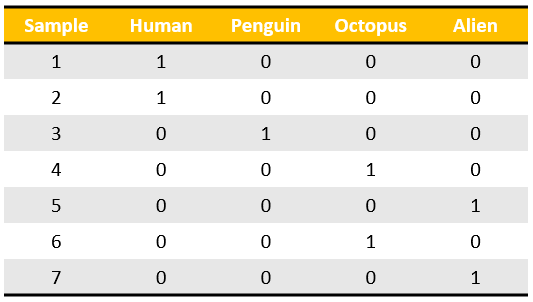

In [5]:
width_size = 1000
Image('pics/onehot.png', width=width_size)

Nel nostro dataset compaiono 3 variabili categoriche:

- giorno della settimana
- nome apparato
- tipo apn

ci sarebbe anche la location ma è sussunta del nome dell'apparato per cui ridondante.

notate che il tipo di apn in questo caso è binario per come l'ho trattato (is_ibox). Le variabili binarie sono un caso particolare di dati categorici con 2 categorie e hanno una rappresentazione compatta.

Per convertire le variabili con one-hot-encoding possiamo usare scikit_learn o pandas. Ad esempio:

In [6]:
dff = pd.get_dummies(dff, columns=['dayofweek', 'name'] )
dff = dff.reset_index().set_index(['location', 'apn', 'd  atetime']).sort_index()
dff = dff.dropna() 
print('shape:', dff.shape)
dff.head() 

shape: (239114, 23)


download3G    download4G  \
location apn         datetime                                          
CB       ibox.tim.it 2016-12-01 00:00:00  1.444864e+11  1.223660e+11   
                     2016-12-01 00:15:00  1.330424e+11  1.132276e+11   
                     2016-12-01 00:30:00  1.145610e+11  9.745850e+10   
                     2016-12-01 00:45:00  1.005404e+11  8.736008e+10   
                     2016-12-01 01:00:00  8.626180e+10  7.939344e+10   

                                          sessions3G  sessions4G  attempted4G  \
location apn         datetime                                                   
CB       ibox.tim.it 2016-12-01 00:00:00     48334.0     39031.0       1721.0   
                     2016-12-01 00:15:00     47255.0     38427.0       1329.0   
                     2016-12-01 00:30:00     46426.0     38014.0       1310.0   
                     2016-12-01 00:45:00     45756.0     37761.0       1193.0   
                     2016-12-01 01:00:00     44464.0     37872.0      13033.0   

                                          attempted3G  is_ibox  timeofday  \
location apn         datetime                                               
CB       ibox.tim.it 2016-12-01 00:00:00      14481.0        1          0   
                     2016-12-01 00:15:00      13327.0        1         15   
                     2016-12-01 00:30:00      12740.0        1         30   
                     2016-12-01 00:45:00      12147.0        1         45   
                     2016-12-01 01:00:00      26534.0        1         60   

                                          dayofweek_0  dayofweek_1  \
location apn         datetime                                        
CB       ibox.tim.it 2016-12-01 00:00:00            0            0   
                     2016-12-01 00:15:00            0            0   
                     2016-12-01 00:30:00            0            0   
                     2016-12-01 00:45:00            0            0   
                     2016-12-01 01:00:00            0            0   

                                          dayofweek_2  dayofweek_3  \
location apn         datetime                                        
CB       ibox.tim.it 2016-12-01 00:00:00            0            1   
                     2016-12-01 00:15:00            0            1   
                     2016-12-01 00:30:00            0            1   
                     2016-12-01 00:45:00            0            1   
                     2016-12-01 01:00:00            0            1   

                                          dayofweek_4  dayofweek_5  \
location apn         datetime                                        
CB       ibox.tim.it 2016-12-01 00:00:00            0            0   
                     2016-12-01 00:15:00            0            0   
                     2016-12-01 00:30:00            0            0   
                     2016-12-01 00:45:00            0            0   
                     2016-12-01 01:00:00            0            0   

                                          dayofweek_6  name_QGGSBO005  \
location apn         datetime                                           
CB       ibox.tim.it 2016-12-01 00:00:00            0               0   
                     2016-12-01 00:15:00            0               0   
                     2016-12-01 00:30:00            0               0   
                     2016-12-01 00:45:00            0               0   
                     2016-12-01 01:00:00            0               0   

                                          name_QGGSCT003  name_QGGSMI013  \
location apn         datetime                                              
CB       ibox.tim.it 2016-12-01 00:00:00               0               0   
                     2016-12-01 00:15:00               0               0   
                     2016-12-01 00:30:00               0               0   
                     2016-12-01 00:45:00               0          